In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load JSON file
file_path = "../data/playback_data/EsdkPlaybackStats.json"  # Update with your actual path
df = pd.read_json(file_path)

# Display first few rows
df.head()

,timestamp_utc,context_receiver_service_timestamp,context_time,message_build_product,message_delivery_latency_ms,message_delivery_type,message_delivery_underruns,message_delivery_underruns_low_buffer,message_delivery_underruns_rejection,message_download_underrun_timeouts,...,message_external_stutters,message_integration_to_playback_latency_ms,message_ms_latency,message_pipeline_stalls,message_pipeline_underruns,message_playback_id,message_playback_initiated,message_rejection_count,message_revision,message_token_limit_count
0,1970-01-01 07:50:28.472000+00:00,1733975702203,28228472,esdk,NaN,media,NaN,NaN,NaN,NaN,...,NaN,1803,NaN,NaN,NaN,f6+Kzkv9M6shTszn0Uw3JA==,progress,NaN,63766717,NaN
1,1970-01-01 00:39:08.815000+00:00,1735379599354,2348815,esdk,NaN,media,NaN,NaN,NaN,NaN,...,NaN,1814,NaN,NaN,NaN,qzpr9xkkAa1pI+QOGYTPbg==,progress,NaN,63766717,NaN
2,1970-01-03 11:43:47.908000+00:00,1731024979753,215027908,esdk,NaN,media,NaN,NaN,NaN,NaN,...,NaN,1779,NaN,NaN,NaN,d8DNQiy7IM2VY4q+09umdg==,progress,NaN,63766717,NaN
3,1970-01-01 06:06:46.489000+00:00,1735399257148,22006489,esdk,NaN,media,NaN,NaN,NaN,NaN,...,NaN,1893,NaN,NaN,NaN,8Wag1qIAKPkyXAREjC3V4A==,progress,NaN,63766717,NaN
4,1970-01-01 05:40:46.559000+00:00,1733108002294,20446559,esdk,449.0,media,NaN,NaN,NaN,NaN,...,NaN,47,NaN,NaN,NaN,txtVLoMsEANqFAisLOKZ4Q==,remote,NaN,63766717,NaN


In [3]:
# Check for missing values
missing_values = df.isnull().sum()
missing_values[missing_values > 0]  # Show only columns with missing values

message_delivery_latency_ms              630
message_delivery_underruns               676
message_delivery_underruns_low_buffer    676
message_delivery_underruns_rejection     676
message_download_underrun_timeouts       676
message_download_underruns               674
message_external_stutters                676
message_ms_latency                       676
message_pipeline_stalls                  676
message_pipeline_underruns               676
message_rejection_count                  676
message_token_limit_count                676
dtype: int64

In [4]:
df.nunique()

timestamp_utc                                 676
context_receiver_service_timestamp            676
context_time                                  676
message_build_product                           1
message_delivery_latency_ms                    43
message_delivery_type                           1
message_delivery_underruns                      0
message_delivery_underruns_low_buffer           0
message_delivery_underruns_rejection            0
message_download_underrun_timeouts              0
message_download_underruns                      1
message_external_stutters                       0
message_integration_to_playback_latency_ms    494
message_ms_latency                              0
message_pipeline_stalls                         0
message_pipeline_underruns                      0
message_playback_id                           676
message_playback_initiated                      3
message_rejection_count                         0
message_revision                                1


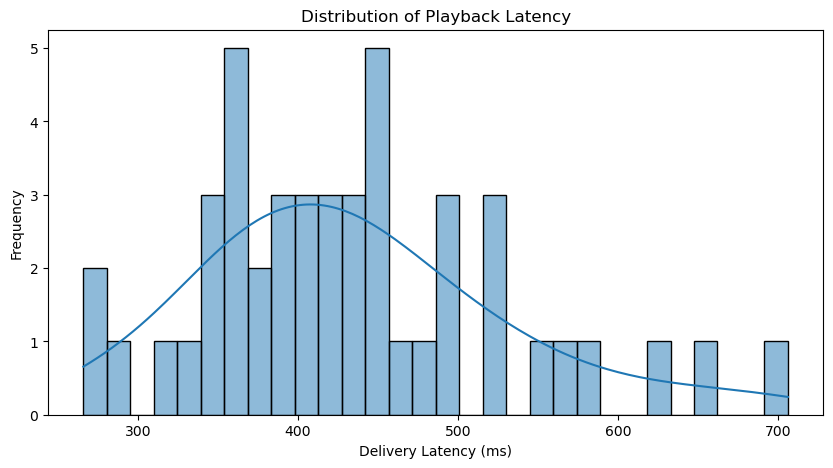

In [5]:
# Latency Distribution
plt.figure(figsize=(10, 5))
sns.histplot(df['message_delivery_latency_ms'].dropna(), bins=30, kde=True)
plt.xlabel("Delivery Latency (ms)")
plt.ylabel("Frequency")
plt.title("Distribution of Playback Latency")
plt.show()

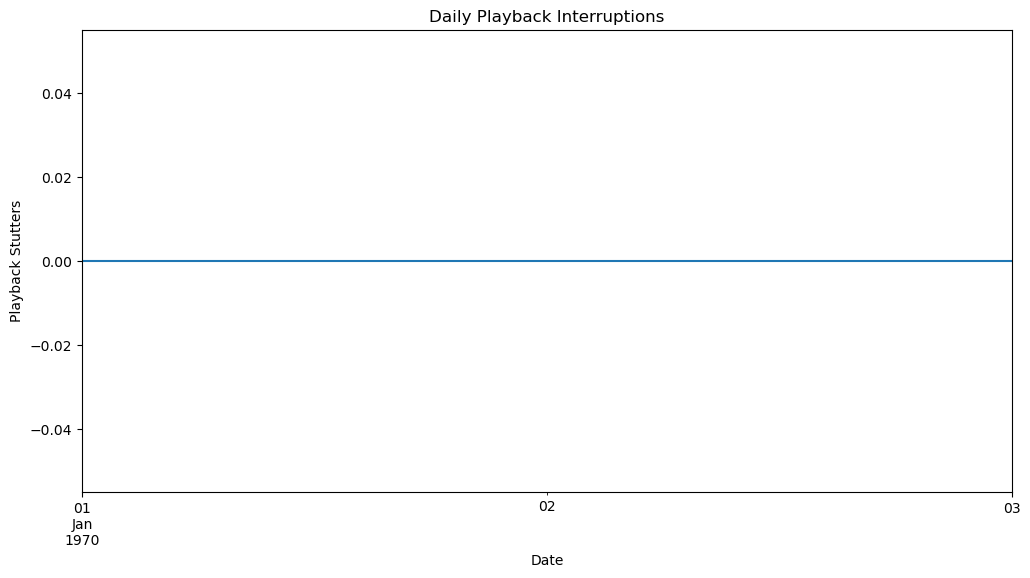

In [6]:
# Playback interruption trends
df['timestamp_utc'] = pd.to_datetime(df['timestamp_utc'])  # Convert timestamps
df.set_index('timestamp_utc', inplace=True)  # Set as index

plt.figure(figsize=(12, 6))
df['message_external_stutters'].resample('D').sum().plot()
plt.xlabel("Date")
plt.ylabel("Playback Stutters")
plt.title("Daily Playback Interruptions")
plt.show()

# **Predicting Playback Interruptions**

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [8]:
# Define target variable (1 = stutter occurred, 0 = no stutter)
df['stutter_occurred'] = df['message_external_stutters'].fillna(0).apply(lambda x: 1 if x > 0 else 0)

In [9]:
# Select features
features = ['message_delivery_latency_ms', 'message_integration_to_playback_latency_ms']
df_clean = df[features + ['stutter_occurred']].dropna()

In [10]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(df_clean[features], df_clean['stutter_occurred'], test_size=0.2, random_state=42)

In [12]:
# Train a model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [13]:
# Predict and evaluate
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10

